In [1]:
from modules._models_v2 import BurgersEquation, create_dense_model
from modules.data import simulate_burgers
from modules.plots import plot_training_loss_linlog, plot_burgers_model
from modules.utils import load_mat_data
import numpy as np
import tensorflow as tf

2022-12-29 03:51:53.760432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = load_mat_data('./data/burgers_shock.mat')
x = data['x']
t = data['t']
# create a meshgrid
X, T = np.meshgrid(x, t)
# flatten the meshgrid
tx_train = np.hstack((T.flatten()[:,None], X.flatten()[:,None]))
u_train = data['usol'].T.flatten()[:,None]
# convert to tf
tx_train = tf.convert_to_tensor(tx_train, dtype=tf.float32)
u_train = tf.convert_to_tensor(u_train, dtype=tf.float32)

2022-12-29 03:51:57.201827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 03:51:57.282411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 03:51:57.282696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 03:51:57.283279: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [3]:
# n_samples = tx_train.shape[0]

In [4]:
# randomly pick n_samples from the tx_samples
n_samples = 4000
idx = np.random.choice(tx_train.shape[0], n_samples, replace=False)
tx_train = tf.gather(tx_train, idx)
u_train = tf.gather(u_train, idx)

In [5]:
(_, y_samples), (tx_init, u_init), (tx_boundary, u_boundary) = simulate_burgers(n_samples)
inputs = [tx_train, tx_init, tx_boundary]
outputs = [u_train, y_samples, u_init, u_boundary]

In [6]:
backbone = create_dense_model([20]*8, 'tanh', 'GlorotNormal', n_inputs = 2, n_outputs = 1)
pinn = BurgersEquation(backbone, 0.01/np.pi)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.95)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
pinn.compile(optimizer=optimizer)

In [7]:
history = pinn.fit(inputs, outputs, epochs=5000, batch_size=500, verbose=0)

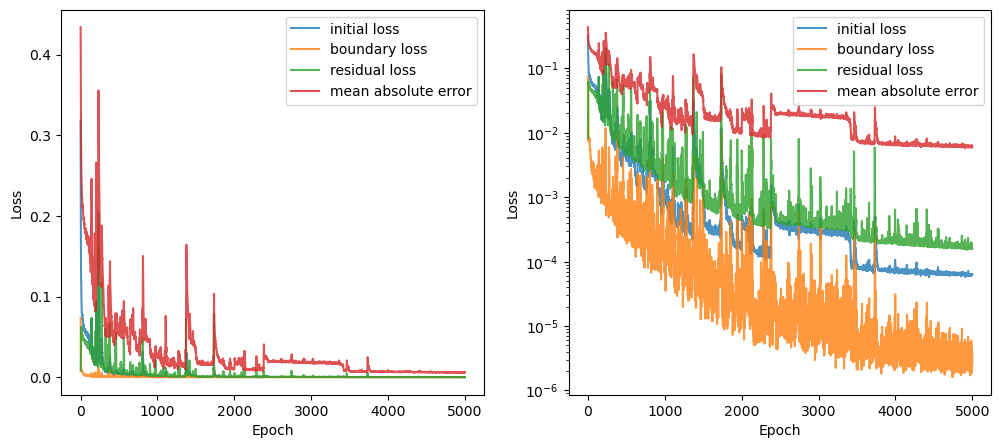

In [8]:
plot_training_loss_linlog(history.history)

1/1 [==============================] - 0s 21ms/step


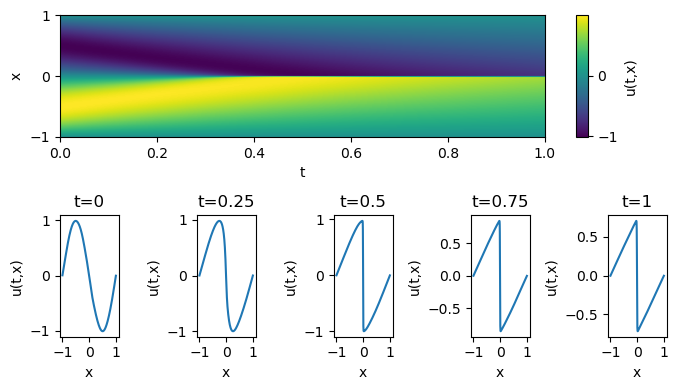

In [9]:
plot_burgers_model(pinn.backbone)

In [10]:
from modules.plots import plot_pointwise_error_mesh

In [11]:
data = load_mat_data('./data/burgers_shock.mat')
x = data['x']
t = data['t']
# create a meshgrid
X, T = np.meshgrid(x, t)
# flatten the meshgrid
tx_train = np.hstack((T.flatten()[:,None], X.flatten()[:,None]))
u_train = data['usol'].T.flatten()[:,None]
# convert to tf
# tx_train = tf.convert_to_tensor(tx_train, dtype=tf.float32)
# u_train = tf.convert_to_tensor(u_train, dtype=tf.float32)

800/800 [==============================] - 2s 2ms/step


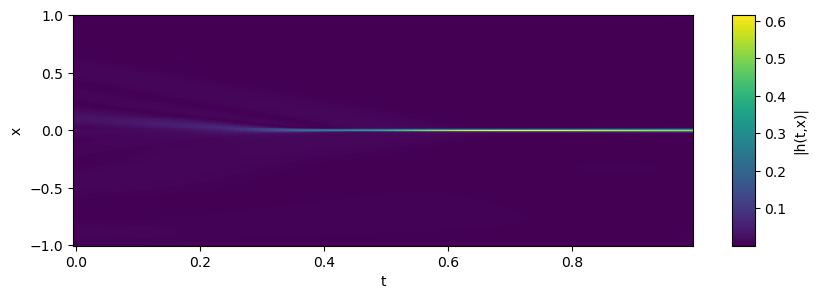

In [12]:
plot_pointwise_error_mesh(pinn.backbone.predict(tx_train), u_train, T, X, figsize=(10, 3))